# Notebook 2: Vertical Slice Gravity wave

In this notebook we will demonstrate running the Compressible Euler equations with a gravity wave. This will evolve solution variables of the velocity $\textbf{u}$, the dry density $\rho$, and the (virtual dry) potential temperature $\theta$. We will then analyse a vertical slice of the potential temperature. 

The initial conditions for this are given in the paper: Klemp, J. B., Rotunno, R., & Skamarock, W. C. (1994). On the dynamics of gravity currents in a channel. Journal of Fluid Mechanics, 269, 169-198.

We begin by importing the required libraries and functions from Firedrake and Gusto:

In [2]:
from petsc4py import PETSc
PETSc.Sys.popErrorHandler()
from gusto import *
import itertools
from firedrake import (as_vector, SpatialCoordinate, PeriodicIntervalMesh,
                       ExtrudedMesh, exp, sin, Function)
import numpy as np
import sys

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


We now define the time-step size, simulation duration, and frequency of output results.

In [2]:
dt = 6.
tmax = 3600.
dumpfreq = int(tmax / (2*dt))

For this vertical slice model, we firstly define a horizontal periodic interval mesh? A number of layers and columns for the flow are defined. We then need to extrude the periodic mesh in the vertical direction for the number of layers.

In [3]:
nlayers = 10  # horizontal layers
columns = 150  # number of columns
L = 3.0e5
m = PeriodicIntervalMesh(columns, L)

H = 1.0e4  # Height position of the model top
mesh = ExtrudedMesh(m, layers=nlayers, layer_height=H/nlayers)

With this test case, we want to look at point data across a vertical slice. This means we need to define points where we record diagnostic data.

In [4]:
points_x = np.linspace(0., L, 100)
points_z = [H/2.]
points = np.array([p for p in itertools.product(points_x, points_z)])

We will call the output folder 'sk_nonlinear'. 

In [5]:
dirname = 'sk_nonlinear'

output = OutputParameters(dirname=dirname,
                          dumpfreq=dumpfreq,
                          pddumpfreq=dumpfreq,
                          dumplist=['u'],
                          perturbation_fields=['theta', 'rho'],
                          point_data=[('theta_perturbation', points)],
                          log_level='INFO')

Now, define the parameters and diagnostics we want to record. We are interested in the temperature gradients, which can be found using the Gradient() function. 

In [6]:
parameters = CompressibleParameters()
g = parameters.g
Tsurf = 300.

diagnostic_fields = [CourantNumber(), Gradient("u"),
                     Gradient("theta_perturbation"),
                     RichardsonNumber("theta", g/Tsurf), Gradient("theta")]

state = State(mesh,
              dt=dt,
              output=output,
              parameters=parameters,
              diagnostic_fields=diagnostic_fields)

gusto:INFO Physical parameters that take non-default values:
gusto:INFO 


A state is initialised from these choices. We also select that we wish to solve the Compressible Euler Equations, with order 1 Continuous Galerkin finite elements (I think?)

In [7]:
state = State(mesh,
              dt=dt,
              output=output,
              parameters=parameters,
              diagnostic_fields=diagnostic_fields)

eqns = CompressibleEulerEquations(state, "CG", 1)

gusto:INFO Physical parameters that take non-default values:
gusto:INFO 


Set up the initial conditions and define the thermodynamic constants.

In [8]:
# Initial conditions
u0 = state.fields("u")
rho0 = state.fields("rho")
theta0 = state.fields("theta")

# spaces
Vu = state.spaces("HDiv")
Vt = state.spaces("theta")
Vr = state.spaces("DG")

# Thermodynamic constants required for setting initial conditions
# and reference profiles
g = parameters.g
N = parameters.N
p_0 = parameters.p_0
c_p = parameters.cp
R_d = parameters.R_d
kappa = parameters.kappa

x, z = SpatialCoordinate(mesh)

# N^2 = (g/theta)dtheta/dz => dtheta/dz = theta N^2g => theta=theta_0exp(N^2gz)
Tsurf = 300.
thetab = Tsurf*exp(N**2*z/g)

theta_b = Function(Vt).interpolate(thetab)
rho_b = Function(Vr)

We compute the hydrostatic Exner pressure, using a hydrostatic balance routine, and apply this to the initial state.

In [9]:
compressible_hydrostatic_balance(state, theta_b, rho_b)

We now set up the initial potential temperature profile. We apply a perturbation of:
$$\Theta' = \Delta \Theta \frac{sin(\pi \frac{z}{H})}{1 + \frac{(x-x_c)^2}{a^2}}$$

In [10]:
a = 5.0e3
deltaTheta = 1.0e-2
theta_pert = deltaTheta*sin(np.pi*z/H)/(1 + (x - L/2)**2/a**2)
theta0.interpolate(theta_b + theta_pert)
rho0.assign(rho_b)
u0.project(as_vector([20.0, 0.0]))

state.set_reference_profiles([('rho', rho_b),
                              ('theta', theta_b)])

Set up the linear solver and the time-stepper. We will again use an Implicit Midpoint method for the velocity field, and the explicit SSPRK3 scheme for the density and potential temperature. We need to specify that a compressible solver is needed.

In [11]:
supg = True
if supg:
    theta_opts = SUPGOptions()
else:
    theta_opts = EmbeddedDGOptions()
transported_fields = [ImplicitMidpoint(state, "u"),
                      SSPRK3(state, "rho"),
                      SSPRK3(state, "theta", options=theta_opts)]

# Set up linear solver
linear_solver = CompressibleSolver(state, eqns)

# build time stepper
stepper = CrankNicolson(state, eqns, transported_fields,
                        linear_solver=linear_solver)

Solve the equations!

In [12]:
#Here's what you would do...
#stepper.run(t=0, tmax=tmax)

/home/timandrews/firedrake/src/firedrake/firedrake/checkpointing.py:89: DeprecationWarning: DumbCheckpoint class will be deprecated after 01/01/2023; use CheckpointFile class instead.
  warnings.warn("DumbCheckpoint class will be deprecated after 01/01/2023; use CheckpointFile class instead.",
gusto:INFO at start of timestep, t=0, dt=6.0
gusto:INFO at start of timestep, t=6.0, dt=6.0
gusto:INFO at start of timestep, t=12.0, dt=6.0
gusto:INFO at start of timestep, t=18.0, dt=6.0
gusto:INFO at start of timestep, t=24.0, dt=6.0
gusto:INFO at start of timestep, t=30.0, dt=6.0
gusto:INFO at start of timestep, t=36.0, dt=6.0
gusto:INFO at start of timestep, t=42.0, dt=6.0
gusto:INFO at start of timestep, t=48.0, dt=6.0
gusto:INFO at start of timestep, t=54.0, dt=6.0
gusto:INFO at start of timestep, t=60.0, dt=6.0
gusto:INFO at start of timestep, t=66.0, dt=6.0
gusto:INFO at start of timestep, t=72.0, dt=6.0
gusto:INFO at start of timestep, t=78.0, dt=6.0
gusto:INFO at start of timestep, t=84

gusto:INFO at start of timestep, t=972.0, dt=6.0
gusto:INFO at start of timestep, t=978.0, dt=6.0
gusto:INFO at start of timestep, t=984.0, dt=6.0
gusto:INFO at start of timestep, t=990.0, dt=6.0
gusto:INFO at start of timestep, t=996.0, dt=6.0
gusto:INFO at start of timestep, t=1002.0, dt=6.0
gusto:INFO at start of timestep, t=1008.0, dt=6.0
gusto:INFO at start of timestep, t=1014.0, dt=6.0
gusto:INFO at start of timestep, t=1020.0, dt=6.0
gusto:INFO at start of timestep, t=1026.0, dt=6.0
gusto:INFO at start of timestep, t=1032.0, dt=6.0
gusto:INFO at start of timestep, t=1038.0, dt=6.0
gusto:INFO at start of timestep, t=1044.0, dt=6.0
gusto:INFO at start of timestep, t=1050.0, dt=6.0
gusto:INFO at start of timestep, t=1056.0, dt=6.0
gusto:INFO at start of timestep, t=1062.0, dt=6.0
gusto:INFO at start of timestep, t=1068.0, dt=6.0
gusto:INFO at start of timestep, t=1074.0, dt=6.0
gusto:INFO at start of timestep, t=1080.0, dt=6.0
gusto:INFO at start of timestep, t=1086.0, dt=6.0
gusto

gusto:INFO at start of timestep, t=1956.0, dt=6.0
gusto:INFO at start of timestep, t=1962.0, dt=6.0
gusto:INFO at start of timestep, t=1968.0, dt=6.0
gusto:INFO at start of timestep, t=1974.0, dt=6.0
gusto:INFO at start of timestep, t=1980.0, dt=6.0
gusto:INFO at start of timestep, t=1986.0, dt=6.0
gusto:INFO at start of timestep, t=1992.0, dt=6.0
gusto:INFO at start of timestep, t=1998.0, dt=6.0
gusto:INFO at start of timestep, t=2004.0, dt=6.0
gusto:INFO at start of timestep, t=2010.0, dt=6.0
gusto:INFO at start of timestep, t=2016.0, dt=6.0
gusto:INFO at start of timestep, t=2022.0, dt=6.0
gusto:INFO at start of timestep, t=2028.0, dt=6.0
gusto:INFO at start of timestep, t=2034.0, dt=6.0
gusto:INFO at start of timestep, t=2040.0, dt=6.0
gusto:INFO at start of timestep, t=2046.0, dt=6.0
gusto:INFO at start of timestep, t=2052.0, dt=6.0
gusto:INFO at start of timestep, t=2058.0, dt=6.0
gusto:INFO at start of timestep, t=2064.0, dt=6.0
gusto:INFO at start of timestep, t=2070.0, dt=6.0


gusto:INFO at start of timestep, t=2940.0, dt=6.0
gusto:INFO at start of timestep, t=2946.0, dt=6.0
gusto:INFO at start of timestep, t=2952.0, dt=6.0
gusto:INFO at start of timestep, t=2958.0, dt=6.0
gusto:INFO at start of timestep, t=2964.0, dt=6.0
gusto:INFO at start of timestep, t=2970.0, dt=6.0
gusto:INFO at start of timestep, t=2976.0, dt=6.0
gusto:INFO at start of timestep, t=2982.0, dt=6.0
gusto:INFO at start of timestep, t=2988.0, dt=6.0
gusto:INFO at start of timestep, t=2994.0, dt=6.0
gusto:INFO at start of timestep, t=3000.0, dt=6.0
gusto:INFO at start of timestep, t=3006.0, dt=6.0
gusto:INFO at start of timestep, t=3012.0, dt=6.0
gusto:INFO at start of timestep, t=3018.0, dt=6.0
gusto:INFO at start of timestep, t=3024.0, dt=6.0
gusto:INFO at start of timestep, t=3030.0, dt=6.0
gusto:INFO at start of timestep, t=3036.0, dt=6.0
gusto:INFO at start of timestep, t=3042.0, dt=6.0
gusto:INFO at start of timestep, t=3048.0, dt=6.0
gusto:INFO at start of timestep, t=3054.0, dt=6.0


To save you having to run the solver (it takes a while!), the results have already been generated and stored in the 'results/sk_nonlinear' subdirectory. This file will now specify how to plot these results and analyse them. 

In [10]:
#from plotting import *
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
from netCDF4 import Dataset
class Plotting(object):

    def __init__(self, filename, field_name, stats=None):

        # get data from file
        try:
            self.data = Dataset(filename, "r")
        except IOError:
            raise ValueError("File %s does not exist" % filename)

        # get time variable
        self.time = list(self.data.variables["time"])

        # get field
        try:
            self.grp = self.data.groups[field_name]
        except KeyError:
            raise ValueError("Field named %s does not exist in this file. You have these fields: %s" % (field_name, [str(f) for f in self.data.groups.keys()]))

        if stats is None:
            self.field = self.grp.variables[field_name]
        else:
            self.stats = []
            for stat in stats:
                try:
                    self.stats.append(self.grp.variables[stat])
                except KeyError:
                    raise ValueError("Stat named %s does not exist for this field. You have these stats: %s" % (stat, [str(s) for s in self.grp.variables.keys()]))


In [12]:
import argparse
import matplotlib.pyplot as plt
import numpy as np


class Plot1DProfile(Plotting):

    def __init__(self, filename, field_name, dim, val, time_entries=None):

        super().__init__(filename, field_name)

        # if no time_entries are specified, plot them all
        if time_entries is not None:
            # check that no time entries exceed the length of the time dimension
            if any(i > len(self.time) for i in time_entries):
                raise ValueError("You cannot plot a time entry greater than %i" % len(self.time))

            self.times = []
            for i in time_entries:
                self.times.append(self.time[i])
            print("Profile will be plotted for times %s :" % [str(t) for t in self.times])
        else:
            time_entries = [i for i in range(len(self.time))]
            self.times = self.time

        # get points
        points = self.grp.variables["points"]

        # check that user has fixed the values of all other dimensions
        if len(val) != points.shape[1]-1:
            raise ValueError("You must fix the values of exactly %s dimensions." % str(points.shape[1]-1))

        # find out which points satisfy requirements
        self.px = []
        idx = []
        for i, p in enumerate(points):
            pq = np.delete(p, [dim])
            if pq == val:
                self.px.append(p[dim])
                idx.append(i)

        if len(idx) == 0:
            raise RuntimeError("No points match your requirements")

        # field values
        self.f = self.field[time_entries, idx]

    def plot(self, same_plot):
        for i in range(len(self.times)):
            print('yo')
            plt.plot(self.px, self.f[i])
            if not same_plot:
                plt.show()

        if same_plot:
            plt.show()



Let's visualise the potential temperature perturbation profile at the start, middle, and end of the simulation.

yo


<IPython.core.display.Javascript object>


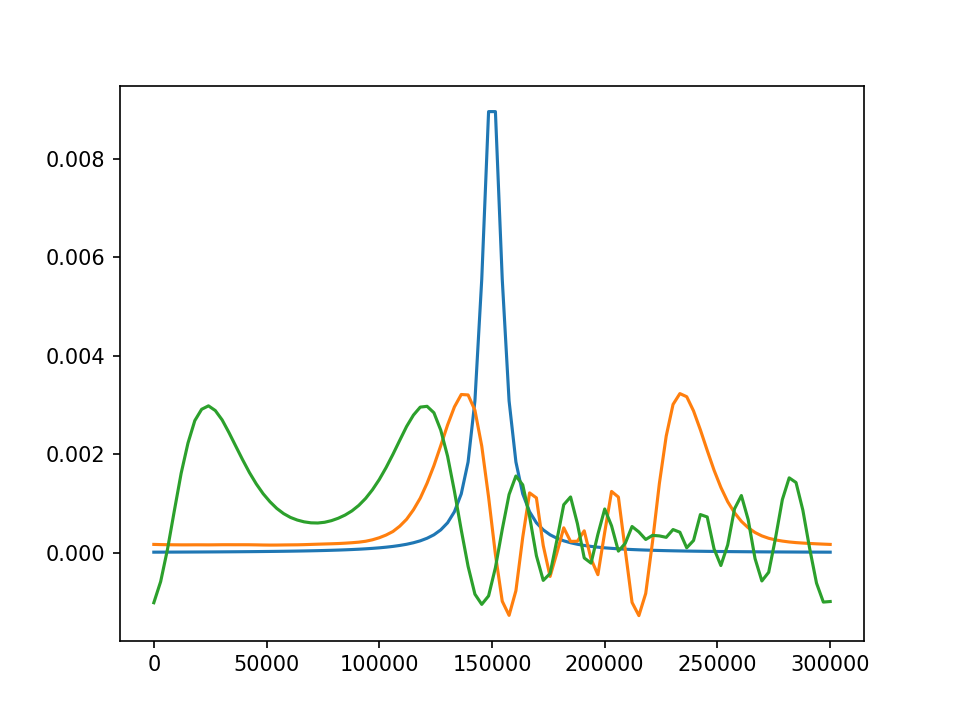

yo
yo


In [18]:
p = Plot1DProfile("results/sk_nonlinear/point_data.nc", "theta_perturbation", 0, [5000])
p.plot(same_plot='True')

We can observe that a quite sharp peak in the initial temperature perturbation smooths out over time.